In [12]:
from helpers.forge_helpers import *
!pip install plotly

## Company-focused EDA: Apple

In [8]:
creds_al = {"username": "anne-louise@vgimfs.com", "password" : "Vanguard.2023", "email": "anne-louise@vgimfs.com", "name" : "Anne"}
cs = get_cursor(profile='Transcripts', creds=creds_al)

Connected to Snowflake version 7.23.1


In [318]:
apple_piers = ('samsung_electronics_gmbh', 'microsoft_corp', 'google','amazon_com_inc','lenovo_group_ltd')

#### Get company transcripts and order them by date

In [319]:
forge_request("""with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.docid, d.title, to_date(docdatetime) as date
    from documents d join co on d.docid = co.docid
    where uri = '{}'
    order by date desc; """.format('http://forge.ai/company/apple_inc'), cs)

,docid,title,date
0,332139141,Apple Q3 2017 Earnings Call,None
1,413167098,Apple Q1 2023 Earnings Call,2023-02-02
2,386997463,Apple Q4 2022 Earnings Call,2022-10-27
3,363424882,Apple Q3 2022 Earnings Call,2022-07-28
4,342666231,Apple Q2 2022 Earnings Call,2022-04-28
...,...,...,...
60,377237406,Apple Q2 2007 Earnings Call,2007-04-25
61,377230662,Apple Q1 2007 Earnings Call,2007-01-17
62,377227477,Apple Q4 2006 Earnings Call,2006-11-02
63,377212986,Apple Q3 2006 Earnings Call,2006-08-09


#### Separate the MD and Q&A parts of the documents

In [320]:
sql_qa = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, dt.name, dt.score, st.title
    from documents d join co on d.docid = co.docid
    join DocumentScores ds on ds.docid = d.docid
    join documenttopics dt on dt.docid = d.docid
    join SourceTexts st on st.docid = d.docid
    where uri = '{}'
    and st.title = 'Q&A'
    order by date desc; """.format('http://forge.ai/company/apple_inc')

sql_md = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, dt.name, dt.score, st.title
    from documents d join co on d.docid = co.docid
    join DocumentScores ds on ds.docid = d.docid
    join documenttopics dt on dt.docid = d.docid
    join SourceTexts st on st.docid = d.docid
    where uri = '{}'
    and st.title = 'Management Discussion'
    order by date desc; """.format('http://forge.ai/company/apple_inc')


topics_qa = forge_request(sql_qa, cs)
topics_md = forge_request(sql_md, cs)



In [321]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

qa_topic_counts = topics_qa['name'].value_counts().head(20)
md_topic_counts = topics_md['name'].value_counts().head(20)

total_qa_docs = len(topics_qa)
total_md_docs = len(topics_md)
qa_relative_freq = qa_topic_counts / total_qa_docs
md_relative_freq = md_topic_counts / total_md_docs

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar(
    x=qa_relative_freq.index,
    y=qa_relative_freq.values,
    name='topics_q&a',
    marker_color='blue'
), row=1, col=1)


fig.add_trace(go.Bar(
    x=md_relative_freq.index,
    y=md_relative_freq.values,
    name='topics_md',
    marker_color='red'
), row=1, col=2)

fig.update_layout(
    title='Top 20 Most Frequent Topics in Q&A and Management Discussion for Apple',
    xaxis_title='Topic',
    yaxis_title='Relative Frequency'
)

fig.show()


In [289]:
sql_ev_qa = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ie.class, st.title, co.uri, ie.confidence
    from documents d join co on d.docid = co.docid
    join DocumentScores ds on ds.docid = d.docid
    join intrinsicevents ie on ie.docid = d.docid
    join SourceTexts st on st.docid = d.docid
    where uri = '{}'
    and st.title = 'Q&A'
    order by date desc; """.format('http://forge.ai/company/apple_inc')

sql_ev_md = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ie.class, st.title, co.uri, ie.confidence
    from documents d join co on d.docid = co.docid
    join DocumentScores ds on ds.docid = d.docid
    join intrinsicevents ie on ie.docid = d.docid
    join SourceTexts st on st.docid = d.docid
    where uri = '{}'
    and st.title = 'Management Discussion'
    order by date desc; """.format('http://forge.ai/company/apple_inc')


events_qa = forge_request(sql_ev_qa, cs)
events_md = forge_request(sql_ev_md, cs)



In [295]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


events_qa_avg = events_qa.groupby('class')['confidence'].mean().reset_index()
events_md_avg = events_md.groupby('class')['confidence'].mean().reset_index()



topics_qa_top20 = events_qa_avg.sort_values('confidence', ascending=False).head(20)
topics_md_top20 = events_md_avg.sort_values('confidence', ascending=False).head(20)

topics_qa_top20['class'] = topics_qa_top20['class'].apply(lambda x: x.replace('SASB Management of the Legal & Regulatory Environment', 'Regulatory Environment'))
topics_md_top20['class'] = topics_md_top20['class'].apply(lambda x: x.replace('SASB Management of the Legal & Regulatory Environment', 'Regulatory Environment'))

fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 20 most important events class in Q&A Sections", "Top 20 most important events class in Management Discussion Sections"))

fig.add_trace(go.Bar(
    x=topics_qa_top20['confidence'],
    y=topics_qa_top20['class'],
    orientation='h',
    name='events_qa',
), row=1, col=1)

fig.update_xaxes(range=[0.6, 1], row=1, col=1)
fig.update_yaxes(showticklabels=True, row=1, col=1)

fig.add_trace(go.Bar(
    x=topics_md_top20['confidence'],
    y=topics_md_top20['class'],
    orientation='h',
    name='events_md'
), row=1, col=2)

fig.update_xaxes(range=[0.6, 1], row=1, col=2)
fig.update_yaxes(showticklabels=True, row=1, col=2)

fig.update_layout(height=500, width=1300, showlegend=False)

fig.show()


#### Plot the relative frequencies of most important topics in MD and Q&A using the topics score

In [229]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


topics_qa_avg = topics_qa.groupby('name')['score'].mean().reset_index()
topics_md_avg = topics_md.groupby('name')['score'].mean().reset_index()



topics_qa_top20 = topics_qa_avg.sort_values('score', ascending=False).head(20)
topics_md_top20 = topics_md_avg.sort_values('score', ascending=False).head(20)

topics_qa_top20['name'] = topics_qa_top20['name'].apply(lambda x: x.replace('SASB Management of the Legal & Regulatory Environment', 'Regulatory Environment'))
topics_md_top20['name'] = topics_md_top20['name'].apply(lambda x: x.replace('SASB Management of the Legal & Regulatory Environment', 'Regulatory Environment'))

fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 20 most important topics in Q&A Sections", "Top 20 most important topics in Management Discussion Sections"))

fig.add_trace(go.Bar(
    x=topics_qa_top20['score'],
    y=topics_qa_top20['name'],
    orientation='h',
    name='topics_qa',
), row=1, col=1)

fig.update_xaxes(range=[0.2, 0.5], row=1, col=1)
fig.update_yaxes(showticklabels=True, row=1, col=1)

fig.add_trace(go.Bar(
    x=topics_md_top20['score'],
    y=topics_md_top20['name'],
    orientation='h',
    name='topics_md'
), row=1, col=2)

fig.update_xaxes(range=[0.2, 0.5], row=1, col=2)
fig.update_yaxes(showticklabels=True, row=1, col=2)

fig.update_layout(height=500, width=1500, showlegend=False)

fig.show()


In [323]:
import pandas as pd
import plotly.graph_objects as go

sql_qa = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, dt.name, dt.score, st.title
    from documents d join co on d.docid = co.docid
    join DocumentScores ds on ds.docid = d.docid
    join documenttopics dt on dt.docid = d.docid
    join SourceTexts st on st.docid = d.docid
    where uri = '{}'
    and st.title = 'Q&A'
    order by date desc; """.format('http://forge.ai/company/apple_inc')

sql_md = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, dt.name, dt.score, st.title
    from documents d join co on d.docid = co.docid
    join DocumentScores ds on ds.docid = d.docid
    join documenttopics dt on dt.docid = d.docid
    join SourceTexts st on st.docid = d.docid
    where uri = '{}'
    and st.title = 'Management Discussion'
    order by date desc; """.format('http://forge.ai/company/apple_inc')


topics_qa = forge_request(sql_qa, cs)
topics_md = forge_request(sql_md, cs)



qa_mean_scores = topics_qa.groupby('name')['score'].mean()

# Filter top 20 names from topics_qa that also exist in topics_md
common_names = list(set(topics_qa['name']).intersection(set(topics_md['name'])))

# Compute the differences of average scores between topics_qa and topics_md for common names
score_differences = qa_mean_scores.loc[common_names] - topics_md.groupby('name')['score'].mean().loc[common_names]

# Create a bar plot using Plotly
fig = go.Figure()

# Add bars for positive differences (topics in Q&A)
fig.add_trace(
    go.Bar(
        x=score_differences[score_differences > 0].index,
        y=score_differences[score_differences > 0].values,
        name='Topics more important in Q&A',
        marker_color='red'
    )
)

# Add bars for negative differences (topics in MD)
fig.add_trace(
    go.Bar(
        x=score_differences[score_differences < 0].index,
        y=score_differences[score_differences < 0].values,
        name='Topics more important in MD',
        marker_color='blue'
    )
)

fig.update_layout(
    title="Differences of topics importance between Q&A session and management discussion section",
    xaxis_title="Name",
    yaxis_title="Score Difference"
)

fig.show()


#### Plot the evolution of sentiment over time for Apple and its peers 

In [99]:
sql_sentiment_apple = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri = '{}'
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by date asc; """.format('http://forge.ai/company/apple_inc')

sentiment_apple = forge_request(sql_sentiment_apple, cs)

sql_sentiment_microsoft = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri = '{}'
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by date asc; """.format('http://forge.ai/company/microsoft_corp')

sentiment_microsoft = forge_request(sql_sentiment_microsoft, cs)

sql_sentiment_google = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri = '{}'
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by date asc; """.format('http://forge.ai/company/google')

sentiment_google = forge_request(sql_sentiment_google, cs)

sql_sentiment_samsung = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri = '{}'
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by date asc; """.format('http://forge.ai/company/samsung_electronics_gmbh')

sentiment_samsung = forge_request(sql_sentiment_samsung, cs)

sql_sentiment_amazon = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri = '{}'
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by date asc; """.format('http://forge.ai/company/amazon_com_inc')

sentiment_amazon= forge_request(sql_sentiment_amazon, cs)

sql_sentiment_lenovo = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri = '{}'
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by date asc; """.format('http://forge.ai/company/lenovo_group_ltd')

sentiment_lenovo= forge_request(sql_sentiment_lenovo, cs)

sql_sentiment_piers = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')

    select d.title, to_date(docdatetime) as date, ds.sentiment
    from documents d join co on d.docid = co.docid
    join DocumentSentiments ds on ds.docid = d.docid
    where uri in ('http://forge.ai/company/apple_inc', 'http://forge.ai/company/microsoft_corp', 'http://forge.ai/company/google','http://forge.ai/company/amazon_com_inc','http://forge.ai/company/lenovo_group_ltd')
    and docdatetime >= DATEADD(DAYS, -1700, CURRENT_TIMESTAMP)
    order by d.title; """
sentiment_piers = forge_request(sql_sentiment_piers, cs)

In [242]:
import plotly.express as px
fig = px.line(sentiment_apple, x='date', y='sentiment', title='Sentiment evolution over time: Apple vs piers')
fig.add_scatter(x=sentiment_microsoft['date'], y=sentiment_microsoft['sentiment'], name='Microsoft')
fig.add_scatter(x=sentiment_samsung['date'], y=sentiment_samsung['sentiment'], name='Samsung')
fig.add_scatter(x=sentiment_amazon['date'], y=sentiment_amazon['sentiment'], name='Amazon')
fig.add_scatter(x=sentiment_lenovo['date'], y=sentiment_lenovo['sentiment'], name='Lenovo')
fig.add_scatter(x=sentiment_apple['date'], y=sentiment_apple['sentiment'], name='Apple')
fig.update_traces(line=dict(width=5), selector=dict(name='Apple'))
fig.show()


## Sector-focused EDA: Pharmaceuticals

In [234]:
data = pd.read_csv('casee_company_uris_metadata.csv')
data

,Unnamed: 0,ticker,uri,region,IG_HY,vgi_sector_1,vgi_sector_2,vgi_sector_3
0,0,A,http://forge.ai/company/agilent_technologies_inc,US,IG,Industrial,Consumer Non-Cyclical,Healthcare
1,3,AAL,http://forge.ai/company/american_airlines_grou...,US,HY,Industrial,Transportation,Airlines
2,7,AAP,http://forge.ai/company/advance_auto_parts_inc,US,IG,Industrial,Consumer Cyclical,Retailers
3,9,AAPL,http://forge.ai/company/apple_inc,US,IG,Industrial,Technology,Technology
4,16,ABBV,http://forge.ai/company/abbvie_inc,US,IG,Industrial,Consumer Non-Cyclical,Pharmaceuticals
...,...,...,...,...,...,...,...,...
1226,5912,SSE,http://forge.ai/company/scottish_and_south,EU,IG,Utility,Electric,Electric
1227,5914,SVT,http://forge.ai/company/severn_trent_plc,EU,IG,Utility,Other Utility,Other Utility
1228,5915,TSCO,http://forge.ai/company/tesco_plc,EU,IG,Industrial,Consumer Non-Cyclical,Supermarkets
1229,5917,ULVR,http://forge.ai/company/unilever_plc,EU,IG,Industrial,Consumer Non-Cyclical,Consumer Products


In [247]:

def get_sector_uris(sector):
    filtered_df = data[data['vgi_sector_3'] == sector]    
    # Return the list of tickers
    result = filtered_df['uri'].tolist()
    return result


In [248]:
sector_uris = get_sector_uris('Pharmaceuticals')
uri_list = "', '".join(sector_uris)  # Convert the list to a comma-separated string

sql = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')



    SELECT d.title, TO_DATE(docdatetime) AS date, ds.sentiment, dt.name, dt.score, co.uri
    FROM Documents d
    JOIN co ON d.docid = co.docid
    JOIN DocumentSentiments ds ON ds.docid = d.docid
    JOIN DocumentTopics dt ON dt.docid = d.docid
    WHERE uri IN ({})
    AND date >= DATEADD(DAYS, -700, CURRENT_TIMESTAMP)
    ORDER BY date DESC; """.format("'" + "', '".join(sector_uris) + "'")
    
sector_df = forge_request(sql, cs)

### Average sentiment by company for pharmaceutical sector

In [258]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sentiment_sector = sector_df.groupby('uri')['sentiment'].mean().reset_index()
sentiment_sector_top20 = sentiment_sector.sort_values('sentiment', ascending=False)

# Extract company name
sentiment_sector_top20['company_name'] = sentiment_sector_top20['uri'].apply(lambda x: x.split('/')[-1].replace('_', ' ').capitalize())

fig = go.Figure(data=[go.Bar(x=sentiment_sector_top20['company_name'], y=sentiment_sector_top20['sentiment'])])

fig.update_layout(
    title='Average sentiment by company since 2021 for the Pharmaceuticals sector',
    xaxis_title='Company',
    yaxis_title='Average Sentiment',
    yaxis_range=[0.2, 0.35]
)
fig.show()


In [297]:
import plotly.graph_objects as go

# Calculate average sentiment for each company
sentiment_sector = sector_df.groupby('uri')['sentiment'].mean().reset_index()
sentiment_sector_top20 = sentiment_sector.sort_values('sentiment', ascending=False)

# Extract company name
sentiment_sector_top20['company_name'] = sentiment_sector_top20['uri'].apply(lambda x: x.split('/')[-1].replace('_', ' ').capitalize())

# Calculate the mean sentiment across all companies
mean_sentiment = sentiment_sector_top20['sentiment'].mean()

# Rescale the sentiment values relative to the mean
sentiment_sector_top20['rescaled_sentiment'] = sentiment_sector_top20['sentiment'] - mean_sentiment

# Assign colors based on sentiment relative to the mean
colors = ['red' if sentiment < 0 else 'green' for sentiment in sentiment_sector_top20['rescaled_sentiment']]

fig = go.Figure(data=[go.Bar(
    x=sentiment_sector_top20['company_name'],
    y=sentiment_sector_top20['rescaled_sentiment'],
    marker=dict(color=colors)
)])

fig.update_layout(
    title='Average sentiment by company since 2021 for the Pharmaceuticals sector',
    xaxis_title='Company',
    yaxis_title='Rescaled Sentiment',
    yaxis_range=[-0.1, 0.1]
)
fig.show()



### Most important topics for pharmaceutical sector

In [259]:
topics_sector = sector_df.groupby('name')['score'].mean().reset_index()
topics_sector_top20 = topics_sector.sort_values('score', ascending=False).head(20)


fig = go.Figure(data=[go.Bar(x=topics_sector_top20['name'], y=topics_sector_top20['score'])])

fig.update_layout(
    title='Most important topics for companies in Pharmaceutical sector since 2021',
    xaxis_title='Topic',
    yaxis_title='Importance',
    yaxis_range=[0.2, 0.6]
)
fig.show()


### Measure evasiveness of companies by sector using the readability score

In [281]:
sector_uris = get_sector_uris('Pharmaceuticals')
uri_list = "', '".join(sector_uris)  # Convert the list to a comma-separated string

sql_evasiveness = """with co as (
          select distinct r.docid, e.uri
          from Relationships r
          left join EntityEquivalentTo e on e.docid = r.docid and e.entityid = r.objectentityid
          where model = 'FACTSQUARED'
            and predicatelabel = 'isCorporateRepresentative')



    SELECT d.title, TO_DATE(docdatetime) AS date, dt.scoretype, dt.score, co.uri
    FROM Documents d
    JOIN co ON d.docid = co.docid
    JOIN DocumentScores dt on dt.docid = d.docid
    WHERE uri IN ({})
    AND date >= DATEADD(DAYS, -700, CURRENT_TIMESTAMP)
    AND dt.scoretype = 'readability'
    ORDER BY date DESC; """.format("'" + "', '".join(sector_uris) + "'")
    
sector_evasiveness = forge_request(sql_evasiveness, cs)

In [286]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sector_evasiveness['score'] = pd.to_numeric(sector_evasiveness['score'], errors='coerce')
sector_evasiveness = sector_evasiveness.dropna(subset=['score'])
sector_evasiveness= sector_evasiveness.groupby('uri')['score'].mean().reset_index()
sector_evasiveness_top = sector_evasiveness.sort_values('score', ascending=True)

sector_evasiveness_top['company_name'] = sector_evasiveness_top['uri'].apply(lambda x: x.split('/')[-1].replace('_', ' ').capitalize())


fig = go.Figure(data=[go.Bar(x=sector_evasiveness_top['company_name'], y=100/sector_evasiveness_top['score'])])

fig.update_layout(
    title='Evasiveness score of companies from the pharmaceutical sector',
    xaxis_title='Company',
    yaxis_title='Average Evasiveness'
)
fig.show()

In [299]:
import plotly.graph_objects as go
import pandas as pd

sector_evasiveness['score'] = pd.to_numeric(sector_evasiveness['score'], errors='coerce')
sector_evasiveness = sector_evasiveness.dropna(subset=['score'])
sector_evasiveness = sector_evasiveness.groupby('uri')['score'].mean().reset_index()
sector_evasiveness_top = sector_evasiveness.sort_values('score', ascending=True)

sector_evasiveness_top['company_name'] = sector_evasiveness_top['uri'].apply(lambda x: x.split('/')[-1].replace('_', ' ').capitalize())

# Calculate the mean evasiveness score across all companies
mean_score = sector_evasiveness_top['score'].mean()

# Rescale the evasiveness scores relative to the mean
sector_evasiveness_top['rescaled_score'] = sector_evasiveness_top['score'] - mean_score

# Assign colors based on score relative to the mean
colors = ['red' if score < 0 else 'green' for score in sector_evasiveness_top['rescaled_score']]

fig = go.Figure(data=[go.Bar(
    x=sector_evasiveness_top['company_name'],
    y=sector_evasiveness_top['rescaled_score'],
    marker=dict(color=colors)
)])

fig.update_layout(
    title='Evasiveness score of companies from the pharmaceutical sector',
    xaxis_title='Company',
    yaxis_title='Rescaled Evasiveness',
    # yaxis_range=[mean_score - 50, mean_score + 50]
)
fig.show()


0        2.72
1        5.70
2        8.74
3       12.41
4       11.24
        ...  
1371    12.86
1372    13.82
1373    10.41
1374     6.53
1375     2.82
Name: score, Length: 1376, dtype: float64


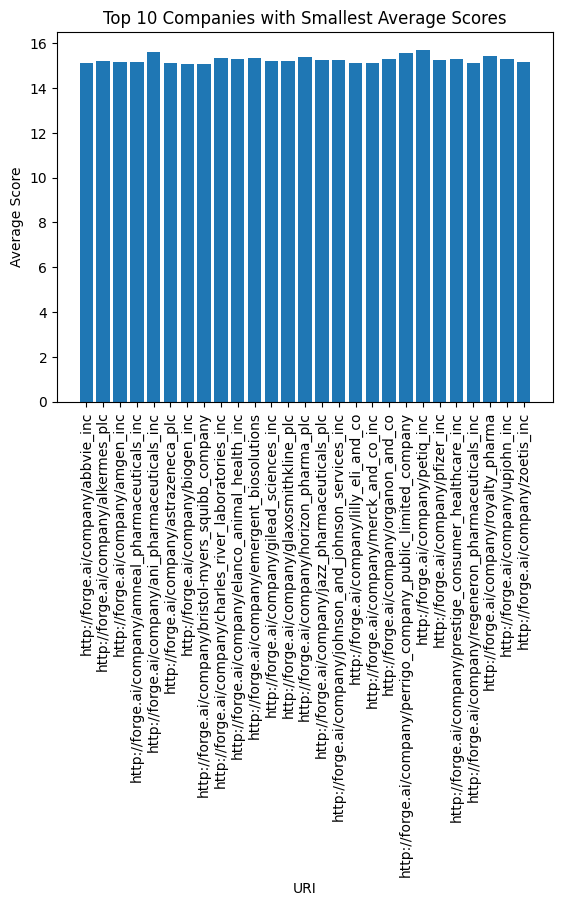

In [280]:
import matplotlib.pyplot as plt

sector_evasiveness['score'] = pd.to_numeric(sector_evasiveness['score'], errors='coerce')

# Drop rows with NaN (non-numeric) values in the 'score' column
sector_evasiveness = sector_evasiveness.dropna(subset=['score'])
print(sector_evasiveness['score'])
average_scores = sector_evasiveness.groupby('uri')['score'].mean()


# Sort the average scores in ascending order and select the 10 smallest


# Plotting the histogram
plt.bar(average_scores.index, average_scores)
plt.xlabel('URI')
plt.ylabel('Average Score')
plt.title('Top 10 Companies with Smallest Average Scores')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility if needed
plt.show()

In [6]:
get_heatmap_data(cs)

,uri,ticker,index_member,call title,date,category,vader
0,http://forge.ai/company/10x_genomics_inc,TXG,RUA,10x Genomics Q1 2023 Earnings Call,2023-05-03,A,0.223385
1,http://forge.ai/company/10x_genomics_inc,TXG,RUA,10x Genomics Q1 2023 Earnings Call,2023-05-03,MD,0.154110
2,http://forge.ai/company/10x_genomics_inc,TXG,RUA,10x Genomics Q1 2023 Earnings Call,2023-05-03,Q,0.267731
3,http://forge.ai/company/10x_genomics_inc,TXG,RUA,10x Genomics Q4 2022 Earnings Call,2023-02-15,A,0.235184
4,http://forge.ai/company/10x_genomics_inc,TXG,RUA,10x Genomics Q4 2022 Earnings Call,2023-02-15,MD,0.233812
...,...,...,...,...,...,...,...
624561,http://forge.ai/company/zynex_inc,ZYXI,RUA,Zynex Q2 2015 Earnings Call,2015-08-13,A,0.351609
624562,http://forge.ai/company/zynex_inc,ZYXI,RUA,Zynex Q2 2015 Earnings Call,2015-08-13,MD,0.150047
624563,http://forge.ai/company/zynex_inc,ZYXI,RUA,Zynex Q4 2014 Earnings Call,2015-04-02,A,0.134858
624564,http://forge.ai/company/zynex_inc,ZYXI,RUA,Zynex Q4 2014 Earnings Call,2015-04-02,MD,0.170166


In [ ]:
q_a_spr_query = """

SELECT dt.name AS Topic_name,
       AVG(CASE WHEN dp.type IN ('Q', 'A') THEN dt.score ELSE NULL END) AS QA_score,
       AVG(CASE WHEN dp.type = 'MD' THEN dt.score ELSE NULL END) AS MD_score
FROM DialogueProperties dp
JOIN Sentences s ON dp.startoffsetmillis = s.startoffset AND dp.docid = s.docid
JOIN DocumentTopics dt ON s.startsentenceid >= dt.startsentenceid AND s.endsentenceid <= dt.endsentenceid
JOIN Co co ON dp.docid = co.docId
WHERE co.uri = 'http://forge.ai/company/apple_inc'
GROUP BY dt.name;"""



## Using FINBert sentiment

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline


In [31]:
# model = AutoModelForSequenceClassification.from_pretrained('helpers/models/04_27_finbert/')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [29]:
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [32]:
get_doc_view_data(378375232, creds_al, cs)

378375232


NameError: name 'classifier' is not defined

### 